# Часть 1. Vanilla Autoencoder 

## 1.1. Подготовка данных 


### Импорт библиотек

In [1]:
! pip install torchinfo

In [1]:
import os
import copy
import torch
import random
import skimage.io
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from copy import deepcopy
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.autograd import Variable
from skimage.transform import resize
import torch.utils.data as data_utils
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec
from torchvision import transforms, datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Фиксация random

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
if device.type == 'cuda':
    !nvidia-smi

Mon Dec 20 22:41:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 29%   33C    P8    11W / 160W |    765MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Cкачивание и подготовка датасета

Установим размер изображения 128х128

In [5]:
def fetch_dataset(attrs_name="lfw_attributes.txt",
                      images_name="lfw-deepfunneled",
                      dx=80, dy=80,
                      dimx=128, dimy=128
    ):

    # download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    # read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns=df_attrs.columns[1:])

    # read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id, 'imagenum':photo_number, 'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    
    # print(photo_ids)
    # mass-merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))

    assert len(df)==len(df_attrs), "lost some data when merging dataframes"

    # print(df.shape)
    # image preprocessing
    all_photos = df['photo_path'].apply(skimage.io.imread)\
                                 .apply(lambda img: img[dy:-dy, dx:-dx])\
                                 .apply(lambda img: resize(img, [dimx,dimy]))

    all_photos = np.stack(all_photos.values) #.astype('uint8')
    file_attrs = df[["photo_path", "person", "imagenum"]].copy()
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)
    
    return all_photos, all_attrs, file_attrs

In [6]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset

data, attrs, file_attrs = fetch_dataset()


Разобъём выборку картинок на train и val и приведём к тензорам pytorch

In [7]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.8, shuffle=False)

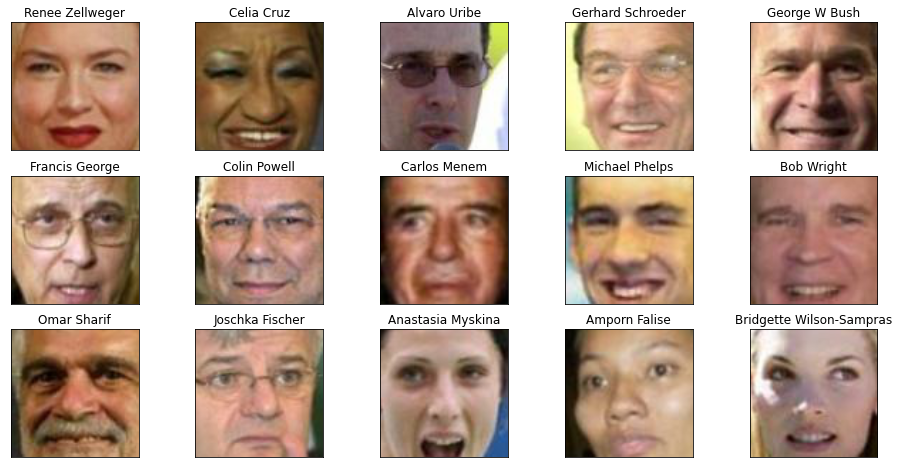

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(16, 8), sharey=True, sharex=True)

for figure in ax.flatten():
    idx = random.randrange(0, train_photos.shape[0])
    figure.imshow(train_photos[idx])
    plt.xticks([])
    plt.yticks([])
    figure.set_title(file_attrs['person'].iloc[idx])
plt.show()

In [8]:
BATCH_SIZE = 32

# numpy.ndarray to tensor_float32 [32, 128, 128, 3] --> [32, 3, 128, 128]
train_photos_t = torch.FloatTensor(train_photos).permute(0, 3, 1, 2) 
val_photos_t = torch.FloatTensor(val_photos).permute(0, 3, 1, 2) 

train_loader = torch.utils.data.DataLoader(train_photos_t, batch_size=BATCH_SIZE, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_photos_t, batch_size=BATCH_SIZE, num_workers=2)

## 1.2. Архитектура модели 
<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code=512):
        super(Autoencoder, self).__init__()
        
        self.dim_code = dim_code

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128*16*16, self.dim_code),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.dim_code, 128*16*16),
            nn.Unflatten(dim=1, unflattened_size=(128, 16, 16)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, sample):
        latent_code = self.encoder(sample)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code
    
    def decode(self, sample):
        reconstruction = self.decoder(sample)
        return reconstruction

In [12]:
summary(Autoencoder().to('cpu'), (32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              --                        --
├─Sequential: 1-1                        [32, 512]                 --
│    └─Conv2d: 2-1                       [32, 32, 64, 64]          896
│    └─BatchNorm2d: 2-2                  [32, 32, 64, 64]          64
│    └─LeakyReLU: 2-3                    [32, 32, 64, 64]          --
│    └─Conv2d: 2-4                       [32, 64, 32, 32]          18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 32, 32]          128
│    └─LeakyReLU: 2-6                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-7                       [32, 128, 16, 16]         73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 16, 16]         256
│    └─LeakyReLU: 2-9                    [32, 128, 16, 16]         --
│    └─Flatten: 2-10                     [32, 32768]               --
│    └─Linear: 2-11                      [32, 512]                 16,777,

In [13]:
criterion = F.mse_loss
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

## 1.3 Обучение 

In [14]:
def train_vanilla(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []
    
    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf
    
    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
        
    for epoch in range(epochs):
        # Train mode
        model.train()
        train_losses_per_epoch = []
        for i, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            reconstructed, latent = model(X_batch)
            loss = criterion(reconstructed, X_batch)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        
        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)
        
        if is_scheduler:
            scheduler.step()
        
        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                X_batch_val = X_batch_val.to(device)
                reconstructed_val, latent_val = model(X_batch_val)
                loss_val = criterion(reconstructed_val, X_batch_val)
                val_losses_per_epoch.append(loss_val.item())
        
        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))
        
        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())
            
        # Visualisations
        clear_output(wait=True)
    
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle(f"epoch:{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 5)}, val_loss:{round(val_loss_mean, 5)}, best_val_loss:{round(best_loss_val, 5)}")

        gs1 = GridSpec(2, 5, left=0.0001, right=0.95, wspace=0.05)
        
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax1.imshow(X_batch_val[0].detach().cpu().permute(1,2,0))
        ax1.set_title('Real')
        ax1.axis('off') 
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax2.imshow(X_batch_val[1].detach().cpu().permute(1,2,0))
        ax2.set_title('Real')
        ax2.axis('off') 
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax3.imshow(X_batch_val[2].detach().cpu().permute(1,2,0))
        ax3.set_title('Real')
        ax3.axis('off') 
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax4.imshow(X_batch_val[3].detach().cpu().permute(1,2,0))
        ax4.set_title('Real')
        ax4.axis('off') 
        ax5 = fig.add_subplot(gs1[:-1, -1])
        ax5.imshow(X_batch_val[4].detach().cpu().permute(1,2,0))
        ax5.set_title('Real')
        ax5.axis('off') 

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax6.imshow(reconstructed_val[0].detach().cpu().permute(1,2,0))
        ax6.set_title('Reconstructed')
        ax6.axis('off') 
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax7.imshow(reconstructed_val[1].detach().cpu().permute(1,2,0))
        ax7.set_title('Reconstructed')
        ax7.axis('off')
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax8.imshow(reconstructed_val[2].detach().cpu().permute(1,2,0))
        ax8.set_title('Reconstructed')
        ax8.axis('off')
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax9.imshow(reconstructed_val[3].detach().cpu().permute(1,2,0))
        ax9.set_title('Reconstructed')
        ax9.axis('off')
        ax10 = fig.add_subplot(gs1[-1, 4])
        ax10.imshow(reconstructed_val[4].detach().cpu().permute(1,2,0))
        ax10.set_title('Reconstructed')
        ax10.axis('off')

        gs2 = GridSpec(2, 2, left=1.01, right=2.0, hspace=0.05)
        
        ax11 = fig.add_subplot(gs2[:, :-1])
        ax11.plot(np.arange(len(train_losses)), train_losses, label='Train')
        ax11.plot(np.arange(len(val_losses)), val_losses, label='Validation')
        ax11.set_ylim(0, max(train_losses+val_losses))
        ax11.set_xlabel('Epoch')
        ax11.set_title('MSE loss')
        ax11.legend()

        plt.show()
        
        # Delete cache
        X_batch.to('cpu')
        del X_batch
        X_batch_val.to('cpu')
        del X_batch_val
        torch.cuda.empty_cache()
        
        # load best model weights
        model.load_state_dict(best_model_weights)

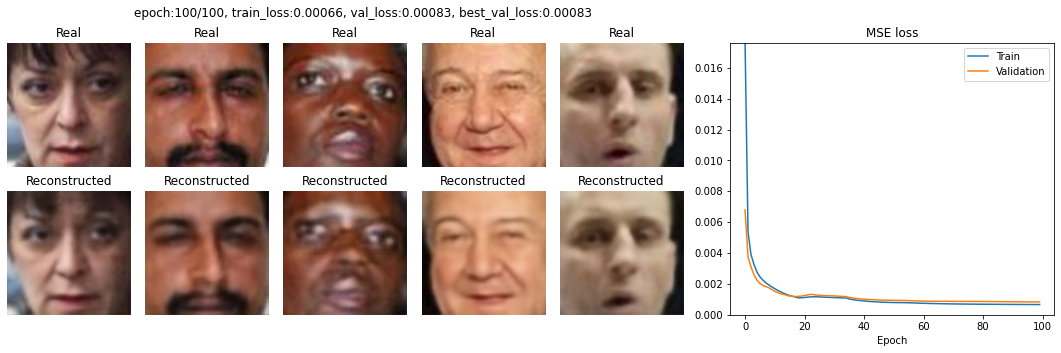

In [15]:
train_vanilla(model=autoencoder, 
              optimizer=optimizer, 
              criterion=criterion, 
              epochs=100, 
              train_loader=train_loader, 
              val_loader=val_loader)

Модель с размером латентного пространства 512 обеспечивает сжатие изображения 128х128х3 в 96 раз и достаточно высокое качество восстанавливаемого изображения

In [16]:
# Save model
torch.save(autoencoder.state_dict(), 'autoencoder.pt')

In [11]:
# Load model
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('autoencoder.pt', map_location=device))
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=32768, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 16, 16))
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output

Давайте посмотрим, как автоэнкодер кодирует и восстанавливает картинки:

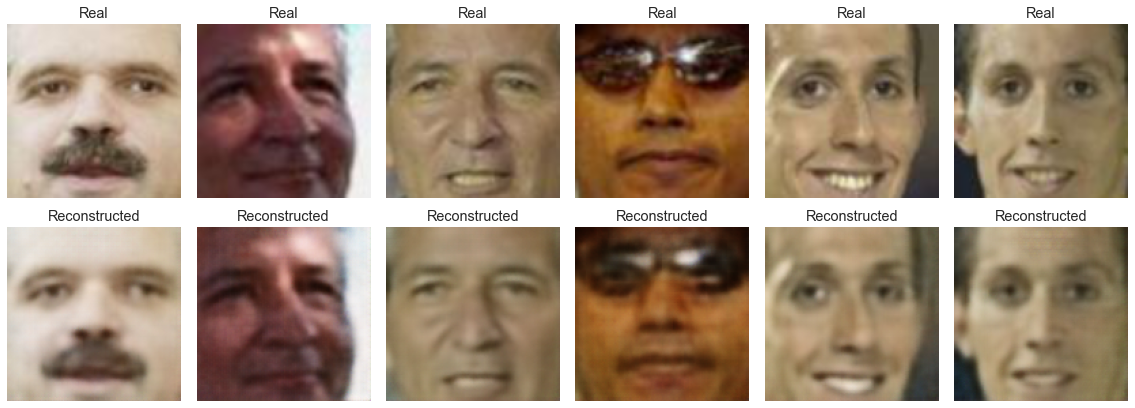

In [92]:
# Выведем первые Х картинок и их реконструкций из val выборки на экран
images = next(iter(val_loader))
autoencoder.eval()
with torch.no_grad():
    reconstructed, latent = autoencoder(images.to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().permute(1,2,0))
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.tight_layout()
plt.show()

## 1.4. Sampling

Теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ.

Подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

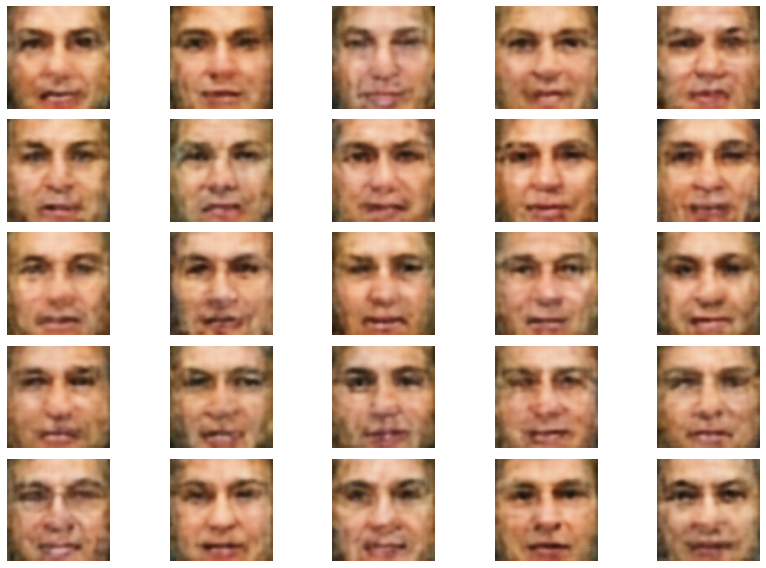

In [19]:
# Получим латетный вектор для всего тренировочного датасета
latents = torch.FloatTensor()
itr = iter(train_loader)
for i in range(len(train_loader)):
    images = next(itr)
    autoencoder.eval()
    with torch.no_grad():
        _, latent = autoencoder(images.to(device))
    latents = torch.cat((latents, latent.cpu()))
    
# Сгенерируем 25 рандомных векторов размера latent_space
# Поправив немного распределение
mu = torch.mean(latents, axis=0) * 2
sigma = torch.std(latents, axis=0) * 0.5
z = sigma * torch.randn(25, latents.shape[1]) + mu

# Сгенерируем семплы
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(torch.FloatTensor(z).to(device))

# Выведем полученные картинки
fig, ax = plt.subplots(5, 5, figsize=(12, 8))
for i in range(5):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().permute(1,2,0))
        axes.axis('off')
plt.tight_layout()
plt.show()

## Smile

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

1. Выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [20]:
# Выберем 20 изображений с улыбающимися людьми
smile_idx = attrs.sort_values('Smiling')[['Smiling']].tail(20).index.tolist()
# И 20 изображений с грустными людьми
sad_idx = attrs.sort_values('Smiling')[['Smiling']].head(20).index.tolist()

In [21]:
# Вычислим латентный вектор для всех улыбающихся людей
latent_smile = torch.FloatTensor().to(device)

for idx in smile_idx:
    smile_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        _, l_smile = autoencoder(smile_image)
    latent_smile = torch.cat((latent_smile, l_smile))

# Вычислим латентный вектор для всех грустных людей
latent_sad = torch.FloatTensor().to(device)   

for idx in sad_idx:
    sad_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        _, l_sad = autoencoder(sad_image)
    latent_sad = torch.cat((latent_sad, l_sad))

# Вычислим вектор улыбки
latent_smile_mean = torch.mean(latent_smile, axis=0)
latent_sad_mean = torch.mean(latent_sad, axis=0)
smile = latent_smile_mean - latent_sad_mean

# Добавим улыбки грустным людям
latent_sad_with_smile = latent_sad + smile
with torch.no_grad():
    output = autoencoder.decode(latent_sad_with_smile)

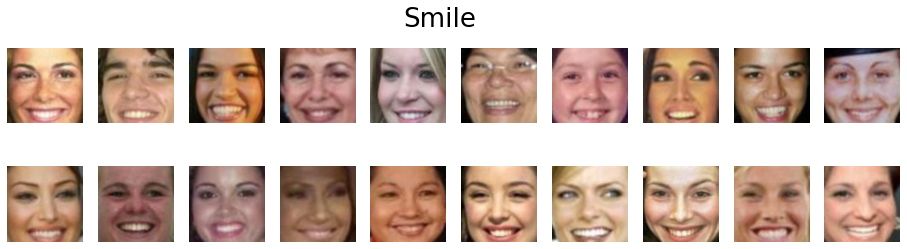

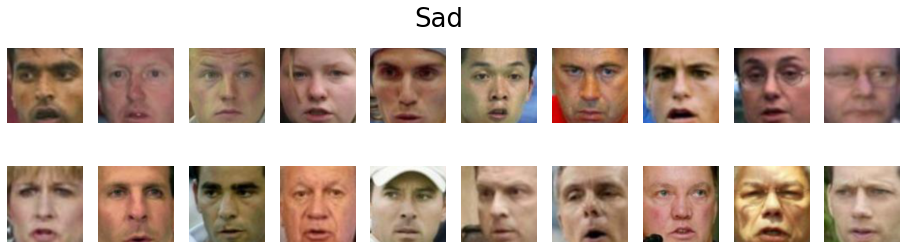

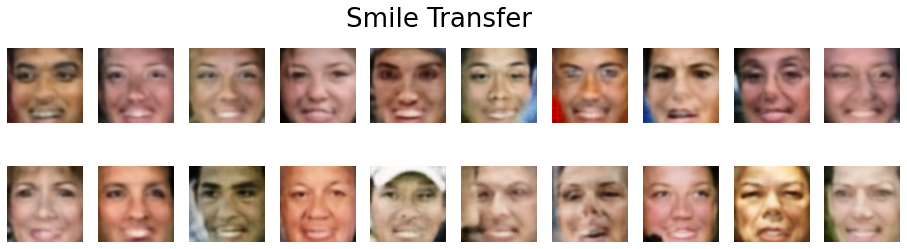

In [22]:
# Визуализируем изображения с улыбающимися людьми
fig, ax = plt.subplots(2, 10, figsize=(16, 4))

for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(data[smile_idx[i]])
    plt.axis('off')
plt.suptitle('Smile', fontsize=26)
plt.show()

# Визуализируем изображения с грустными людьми
fig, ax = plt.subplots(2, 10, figsize=(16, 4))

for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(data[sad_idx[i]])
    plt.axis('off')
plt.suptitle('Sad', fontsize=26)
plt.show()

# Визуализируем грустных людей с добавленными улыбками
fig, ax = plt.subplots(2, 10, figsize=(16, 4))

for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(output[i].cpu().permute(1,2,0))
    plt.axis('off')
plt.suptitle('Smile Transfer', fontsize=26)
plt.show()

Если вам вдруг этого покажется мало и вы хотите видеть больше радости на лицах, то можно увеличить вектор улыбки в два раза

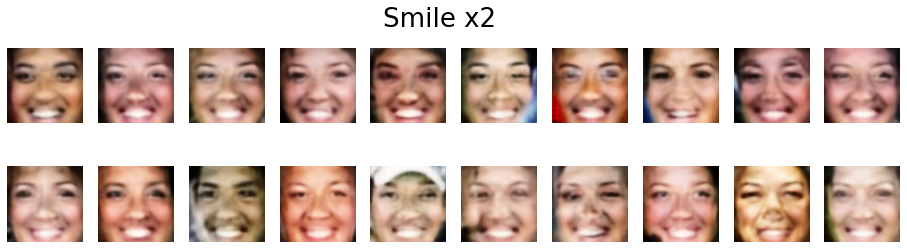

In [23]:
# Добавим вдвое больше радости
latent_sad_with_smile_x2 = latent_sad + smile*2
with torch.no_grad():
    output_x2 = autoencoder.decode(latent_sad_with_smile_x2)
    
# Визуализируем полученный результат
fig, ax = plt.subplots(2, 10, figsize=(16, 4))

for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(output_x2[i].cpu().permute(1,2,0))
    plt.axis('off')
plt.suptitle('Smile x2', fontsize=26)
plt.show()

Теперь все счастливы!

Также можно пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [4]:
batch_size = 32

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение

Реализуем VAE

Установим размер латентного пространства равный четырём

In [11]:
class VAE(nn.Module):
    def __init__(self, dim_code=4):
        super(VAE, self).__init__()
        
        self.dim_code = dim_code
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU())
        
        self.mu = nn.Linear(512, self.dim_code)
        
        self.logsigma = nn.Linear(512, self.dim_code)
        
        self.decoder_input = nn.Linear(self.dim_code, 512)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
        
    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            samples = self.reparameterize(mu, logsigma)
            return samples
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma
    
    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        return z

In [26]:
summary(VAE().to('cpu'), (32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      --                        --
├─Sequential: 1-1                        [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [32, 32, 14, 14]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 14, 14]          64
│    └─LeakyReLU: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 7, 7]            18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 7, 7]            128
│    └─LeakyReLU: 2-6                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 4, 4]           73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 4, 4]           256
│    └─LeakyReLU: 2-9                    [32, 128, 4, 4]           --
│    └─Conv2d: 2-10                      [32, 256, 2, 2]           295,168
│    └─BatchNorm2d: 2-11                 [32, 256, 2, 2]           51

Определим лосс и его компоненты для VAE:

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [7]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)) 

И обучим модель:

In [28]:
criterion = loss_vae
vaeautoencoder = VAE().to(device)
optimizer = torch.optim.AdamW(vaeautoencoder.parameters(), lr=3e-4)

In [15]:
def train_vae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []
    
    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf
    
    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
        
    for epoch in range(epochs):
        # Train mode
        model.train()
        train_losses_per_epoch = []
        for i, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch = X_batch[0].to(device)
            reconstructed, mu, logsigma = model(X_batch)
            loss = criterion(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        
        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)
        
        if is_scheduler:
            scheduler.step()
        
        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                X_batch_val = X_batch_val[0].to(device)
                reconstructed_val, mu_val, logsigma_val = model(X_batch_val)
                loss_val = criterion(X_batch_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())
        
        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))
        
        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())
            
        # Visualisations
        clear_output(wait=True)
    
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle(f"epoch:{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 2)}, val_loss:{round(val_loss_mean, 2)}, best_val_loss:{round(best_loss_val, 2)}")

        gs1 = GridSpec(2, 5, left=0.0001, right=0.95, wspace=0.05)
        
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax1.imshow(X_batch_val[0].detach().cpu().squeeze(0), cmap='gray')
        ax1.set_title('Real')
        ax1.axis('off') 
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax2.imshow(X_batch_val[1].detach().cpu().squeeze(0), cmap='gray')
        ax2.set_title('Real')
        ax2.axis('off') 
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax3.imshow(X_batch_val[2].detach().cpu().squeeze(0), cmap='gray')
        ax3.set_title('Real')
        ax3.axis('off') 
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax4.imshow(X_batch_val[3].detach().cpu().squeeze(0), cmap='gray')
        ax4.set_title('Real')
        ax4.axis('off') 
        ax5 = fig.add_subplot(gs1[:-1, -1])
        ax5.imshow(X_batch_val[4].detach().cpu().squeeze(0), cmap='gray')
        ax5.set_title('Real')
        ax5.axis('off') 

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax6.imshow(reconstructed_val[0].detach().cpu().squeeze(0), cmap='gray')
        ax6.set_title('Reconstructed')
        ax6.axis('off') 
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax7.imshow(reconstructed_val[1].detach().cpu().squeeze(0), cmap='gray')
        ax7.set_title('Reconstructed')
        ax7.axis('off')
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax8.imshow(reconstructed_val[2].detach().cpu().squeeze(0), cmap='gray')
        ax8.set_title('Reconstructed')
        ax8.axis('off')
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax9.imshow(reconstructed_val[3].detach().cpu().squeeze(0), cmap='gray')
        ax9.set_title('Reconstructed')
        ax9.axis('off')
        ax10 = fig.add_subplot(gs1[-1, 4])
        ax10.imshow(reconstructed_val[4].detach().cpu().squeeze(0), cmap='gray')
        ax10.set_title('Reconstructed')
        ax10.axis('off')

        gs2 = GridSpec(2, 2, left=1.01, right=2.0, hspace=0.05)
        
        ax11 = fig.add_subplot(gs2[:, :-1])
        
        ax11.plot(np.arange(len(train_losses)), train_losses, label='Train')
        ax11.plot(np.arange(len(val_losses)), val_losses, label='Validation')
        ax11.set_ylim(0, max(train_losses+val_losses))
        ax11.set_xlabel('Epoch')
        ax11.set_title('VAE loss')
        ax11.legend()

        plt.show()
        
        # Delete cache
        X_batch.to('cpu')
        del X_batch
        X_batch_val.to('cpu')
        del X_batch_val
        torch.cuda.empty_cache()
        
        # load best model weights
        model.load_state_dict(best_model_weights)

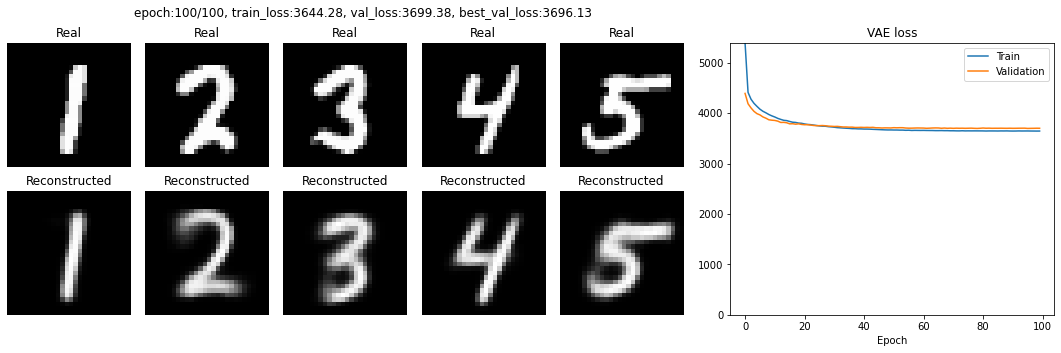

In [30]:
train_vae(model=vaeautoencoder, 
          optimizer=optimizer, 
          criterion=criterion, 
          epochs=100, 
          train_loader=train_loader, 
          val_loader=test_loader)

In [31]:
# Save model
torch.save(vaeautoencoder.state_dict(), 'vaeautoencoder.pt')

In [19]:
# Load model
vaeautoencoder = VAE().to(device)
vaeautoencoder.load_state_dict(torch.load('vaeautoencoder.pt', map_location=device))
vaeautoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

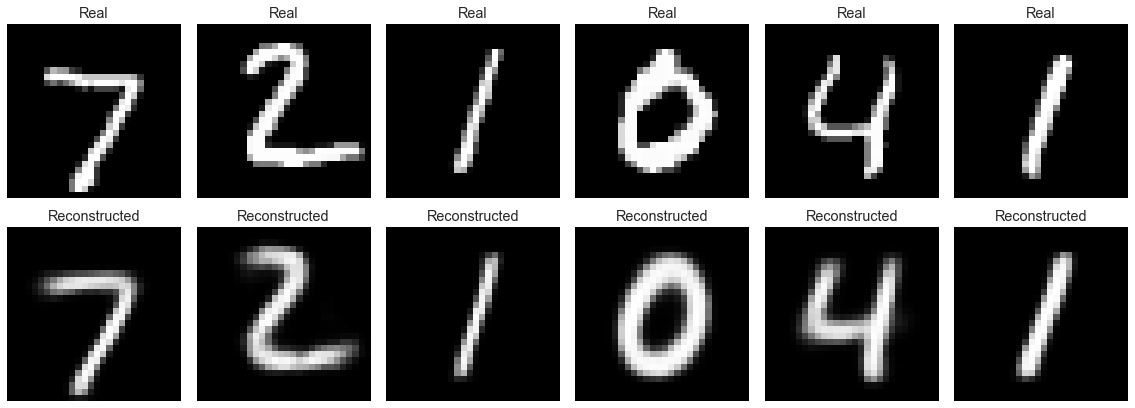

In [21]:
# Выведем первые Х картинок и их реконструкций из val выборки на экран
images = next(iter(test_loader))
images = images[0]
vaeautoencoder.eval()
with torch.no_grad():
    reconstructed, mu, logsigma = vaeautoencoder(images.to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].squeeze(0), cmap='gray')
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().squeeze(0), cmap='gray')
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.tight_layout()
plt.show()

Проверим качество восстановления на всех классах изображений

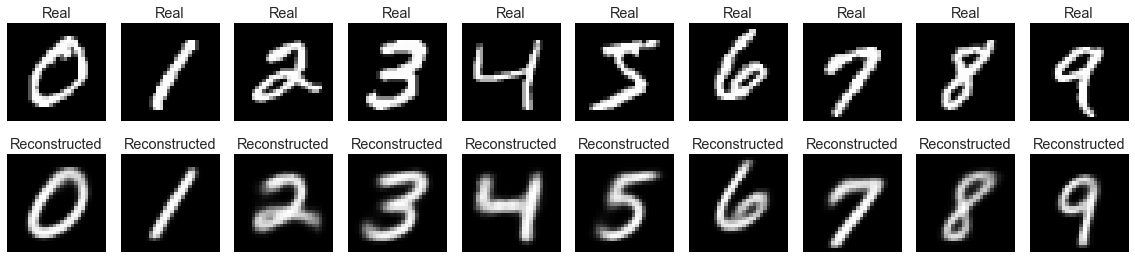

In [23]:
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    for j in test_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            vaeautoencoder.eval()
            with torch.no_grad():
                reconstructed, mu, logsigma = vaeautoencoder(image.to(device))
            ax[0, i].imshow(torch.squeeze(image.cpu()), cmap='gray')
            ax[0, i].axis('off')
            ax[0, i].set_title('Real')
            ax[1, i].imshow(torch.squeeze(reconstructed.cpu()), cmap='gray')
            ax[1, i].axis('off')
            ax[1, i].set_title('Reconstructed')
            break
plt.tight_layout()
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

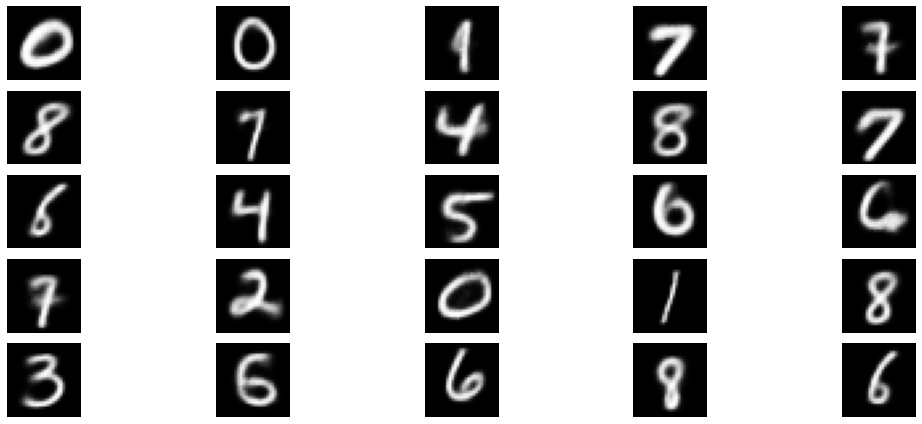

In [35]:
z = np.array([np.random.normal(0, 1, 4) for i in range(25)])
z = torch.FloatTensor(z)
vaeautoencoder.eval()
with torch.no_grad():
    output = vaeautoencoder.decode(z.to(device))
# Выведем полученные изображения
fig, ax = plt.subplots(5, 5, figsize=(16, 6))
for i in range(5):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.axis('off')
plt.tight_layout()
plt.show()

## 2.2. Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Изобразим  латентные векторы картинок точками в двумерном просторанстве. 
Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

1. Получим латентные представления картинок тестового датасета.
2. С помощтю `TSNE` сожмём эти представления до размерности 2.
3. Визуализируем полученные двумерные представления.

In [36]:
# Соберём все лейблы в один список
labels = [i[1] for i in test_dataset]

# Получим тензор латентных векторов для тестового датасета
latents = torch.FloatTensor()
itr = iter(test_loader)
for i in range(len(test_loader)):
    images = next(itr)
    images = images[0]
    vaeautoencoder.eval()
    with torch.no_grad():
        latent = vaeautoencoder.get_latent_vector(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

Размер латентных векторов до TSNE преобразования

In [37]:
latents.shape

torch.Size([10000, 4])

In [38]:
# Выполним сжатие размерностей
latents_tsne = TSNE(n_components=2).fit_transform(latents)

Размер латентных векторов после TSNE преобразования

In [39]:
latents_tsne.shape

(10000, 2)

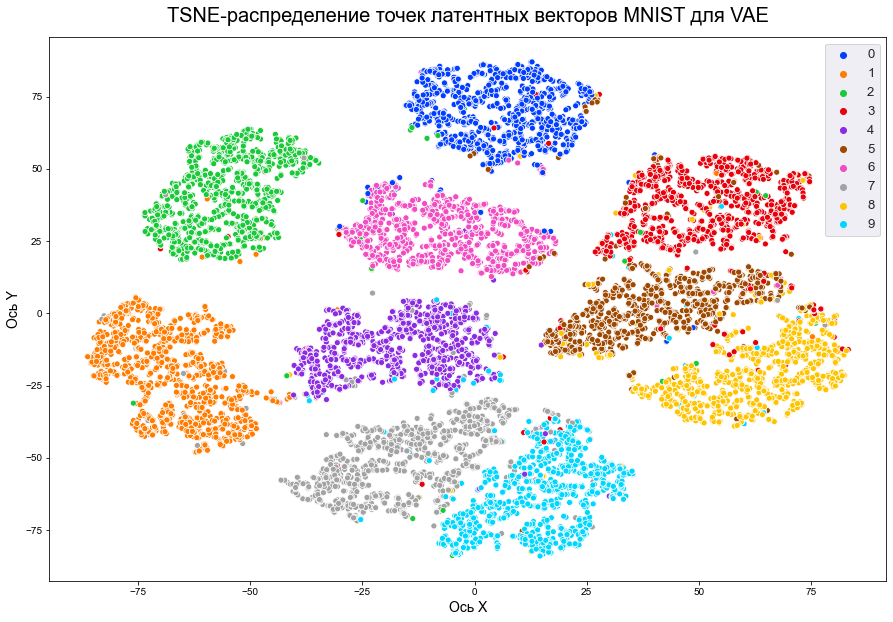

In [40]:
# Визуализируем полученные двумерные представления
fig, ax = plt.subplots(figsize=(15, 10))
sns.set(font_scale=1.2, style='darkgrid')
sns.scatterplot(x=latents_tsne[:, 0], y=latents_tsne[:, 1], hue=labels, palette='bright') 
ax.set_title('TSNE-распределение точек латентных векторов MNIST для VAE', fontsize=20, pad=15)
ax.set_xlabel('Ось X', fontsize=14)
ax.set_ylabel('Ось Y', fontsize=14)
plt.show()

Все данные хорошо кластеризованы. Кластеры пракически не пересекаются между собой, за исключением единичных элементов. Ошибочные реконструкции в большей степени характерны для цифр с округлыми формами (3, 8). В то время как единицы определяются наиболее точно.

## 2.3. Conditional VAE 


### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного - это то, что вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



Это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

Установим размер латентного пространства равный четырём. 

In [6]:
class CVAE(nn.Module):
    def __init__(self, dim_code=4):
        super(CVAE, self).__init__()
        
        self.dim_code = dim_code
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU())
        
        self.mu = nn.Linear(512, self.dim_code)
        
        self.logsigma = nn.Linear(512, self.dim_code)
        
        self.embed_class = nn.Linear(10, 28 * 28)
        
        self.embed_data = nn.ConvTranspose2d(2, 1, kernel_size=1, padding=0, output_padding=0)
        
        self.decoder_input = nn.Linear(self.dim_code+10, 512)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
        
    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x, label):
        labels = F.one_hot(label, num_classes=10)                      # -> (32, 10)
        labels = labels.type_as(torch.FloatTensor()).to(device)        # -> (32, 10)
        embedded_class = self.embed_class(labels)                      # -> (32, 784)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)  # -> (32, 1, 28, 28)
        x = torch.cat([x, embedded_class], dim=1)                      # -> (32, 2, 28, 28)
        x = self.embed_data(x)                                         # -> (32, 1, 28, 28)
        x = self.encoder(x)                                            # -> (32, 512, 1, 1)
        x = torch.flatten(x, start_dim=1)                              # -> (32, 512)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma, labels

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            samples = self.reparameterize(mu, logsigma)
            return samples
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)         # -> (32, 4)
        z = torch.cat([z, labels], dim=1)             # -> (32, 14)
        z = self.decoder_input(z)                     # -> (32, 512)
        z = z.view(-1, 512, 1, 1)                     # -> (32, 512, 1, 1)
        reconstruction = self.decoder(z)              # -> (32, 1, 28, 28)
        return reconstruction, mu, logsigma
    
    def get_latent_vector(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        return z

In [9]:
image, label = next(iter(train_loader))
summary(model=CVAE().to(device), input_data=[image, label])

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     --                        --
├─Linear: 1-1                            [32, 784]                 8,624
├─ConvTranspose2d: 1-2                   [32, 1, 28, 28]           3
├─Sequential: 1-3                        [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [32, 32, 14, 14]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 14, 14]          64
│    └─LeakyReLU: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 7, 7]            18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 7, 7]            128
│    └─LeakyReLU: 2-6                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 4, 4]           73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 4, 4]           256
│    └─LeakyReLU: 2-9                    [32, 128, 4, 4]           --
│ 

Используем ту же лосс функцию, что и для VAE

In [10]:
criterion = loss_vae
cvaeautoencoder = CVAE().to(device)
optimizer = torch.optim.AdamW(cvaeautoencoder.parameters(), lr=3e-4)

In [11]:
def train_cvae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []
    
    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf
    
    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
        
    for epoch in range(epochs):
        # Train mode
        model.train()
        train_losses_per_epoch = []
        for i, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels = X_batch
            images = images.to(device)
            labels = labels.to(device)
            reconstructed, mu, logsigma = model(images, labels)
            loss = criterion(images, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        
        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)
        
        if is_scheduler:
            scheduler.step()
        
        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                images_val, labels_val = X_batch_val
                images_val = images_val.to(device)
                labels_val = labels_val.to(device)
                reconstructed_val, mu_val, logsigma_val = model(images_val, labels_val)
                loss_val = criterion(images_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())
        
        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))
        
        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())
        
        # Visualisations
        clear_output(wait=True)
    
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle(f"epoch:{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 2)}, val_loss:{round(val_loss_mean, 2)}, best_val_loss:{round(best_loss_val, 2)}")

        gs1 = GridSpec(2, 5, left=0.0001, right=0.95, wspace=0.05)
        
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax1.imshow(images_val[0].detach().cpu().squeeze(0), cmap='gray')
        ax1.set_title('Real')
        ax1.axis('off') 
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax2.imshow(images_val[1].detach().cpu().squeeze(0), cmap='gray')
        ax2.set_title('Real')
        ax2.axis('off') 
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax3.imshow(images_val[2].detach().cpu().squeeze(0), cmap='gray')
        ax3.set_title('Real')
        ax3.axis('off') 
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax4.imshow(images_val[3].detach().cpu().squeeze(0), cmap='gray')
        ax4.set_title('Real')
        ax4.axis('off') 
        ax5 = fig.add_subplot(gs1[:-1, -1])
        ax5.imshow(images_val[4].detach().cpu().squeeze(0), cmap='gray')
        ax5.set_title('Real')
        ax5.axis('off') 

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax6.imshow(reconstructed_val[0].detach().cpu().squeeze(0), cmap='gray')
        ax6.set_title('Reconstructed')
        ax6.axis('off') 
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax7.imshow(reconstructed_val[1].detach().cpu().squeeze(0), cmap='gray')
        ax7.set_title('Reconstructed')
        ax7.axis('off')
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax8.imshow(reconstructed_val[2].detach().cpu().squeeze(0), cmap='gray')
        ax8.set_title('Reconstructed')
        ax8.axis('off')
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax9.imshow(reconstructed_val[3].detach().cpu().squeeze(0), cmap='gray')
        ax9.set_title('Reconstructed')
        ax9.axis('off')
        ax10 = fig.add_subplot(gs1[-1, 4])
        ax10.imshow(reconstructed_val[4].detach().cpu().squeeze(0), cmap='gray')
        ax10.set_title('Reconstructed')
        ax10.axis('off')

        gs2 = GridSpec(2, 2, left=1.01, right=2.0, hspace=0.05)
        
        ax11 = fig.add_subplot(gs2[:, :-1])
        ax11.plot(np.arange(len(train_losses)), train_losses, label='Train')
        ax11.plot(np.arange(len(val_losses)), val_losses, label='Validation')
        ax11.set_ylim(0, max(train_losses+val_losses))
        ax11.set_xlabel('Epoch')
        ax11.set_title('CVAE loss')
        ax11.legend()

        plt.show()
        
        # Delete cache
        images.to('cpu')
        del images
        images_val.to('cpu')
        del images_val
        torch.cuda.empty_cache()
        
        # load best model weights
        model.load_state_dict(best_model_weights)

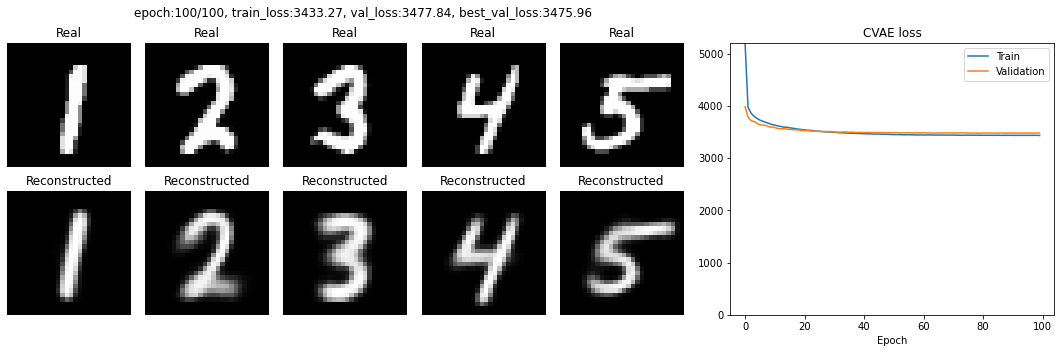

In [12]:
train_cvae(model=cvaeautoencoder, 
           optimizer=optimizer, 
           criterion=criterion, 
           epochs=100, 
           train_loader=train_loader, 
           val_loader=test_loader)

In [13]:
# Save model
torch.save(cvaeautoencoder.state_dict(), 'cvaeautoencoder.pt')

In [7]:
# Load model
cvaeautoencoder = CVAE().to(device)
cvaeautoencoder.load_state_dict(torch.load('cvaeautoencoder.pt', map_location=device))
cvaeautoencoder.eval()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

Давайте посмотрим, как наш тренированный CVAE кодирует и восстанавливает картинки:

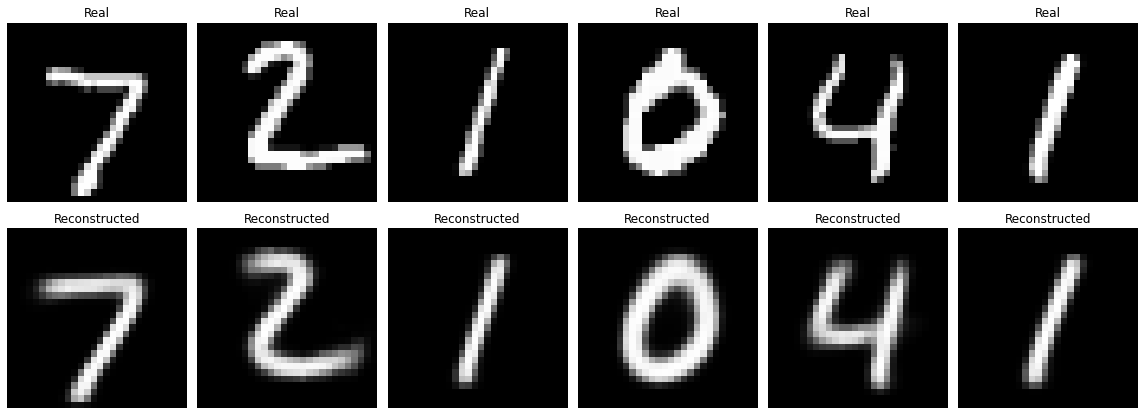

In [9]:
# Выведем первые Х картинок и их реконструкций из val выборки на экран
batch = next(iter(test_loader))
imgs, lbls = batch
cvaeautoencoder.eval()
with torch.no_grad():
    reconstructed, mu, logsigma = cvaeautoencoder(imgs.to(device), lbls.to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(imgs[j].squeeze(0), cmap='gray')
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().squeeze(0), cmap='gray')
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.tight_layout()
plt.show()

Проверим качество восстановления на всех классах изображений

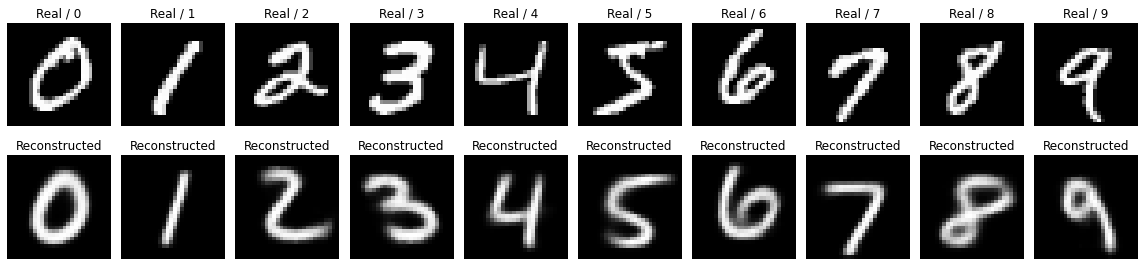

In [8]:
batch_images = torch.FloatTensor()
for i in range(10):
    for j in test_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            batch_images = torch.cat((batch_images, image), dim=0)
            break
reconstructed_val, _, _ = cvaeautoencoder(batch_images.to(device), torch.LongTensor(list(range(10))))

fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    for j in train_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            ax[0, i].imshow(torch.squeeze(image.cpu()), cmap='gray')
            ax[0, i].axis('off')
            ax[0, i].set_title('Real / '+ str(i))
            ax[1, i].imshow(torch.squeeze(reconstructed_val[i].detach().cpu()), cmap='gray')
            ax[1, i].axis('off')
            ax[1, i].set_title('Reconstructed')
            break
plt.tight_layout()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST можно попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

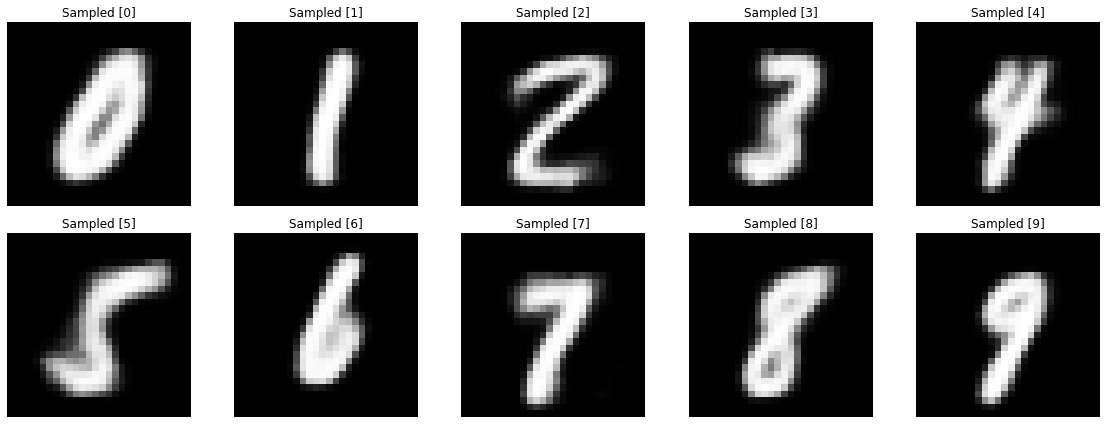

In [10]:
z = torch.randn(1, 4)  # Cлучайный латентный вектор
z = torch.tile(z, dims=(10, 1))  # Батч из 10 одинаковых(!) векторов z
labels = torch.LongTensor(list(range(10)))  # Тензор с лейблами
cvaeautoencoder.eval()
with torch.no_grad():
    output = cvaeautoencoder.decode(z.to(device), labels.to(device))
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
for i in range(2):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.set_title(f'Sampled {[5*i+j]}')
        axes.axis('off')
plt.tight_layout()
plt.show()

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE.

In [11]:
# Соберём все лейблы в один список
labels = [i[1] for i in test_dataset]

# Получим тензор латентных векторов для тестового датасета
latents = torch.FloatTensor()
itr = iter(test_loader)
for batch in test_loader:
    imgs, lbls = batch
    cvaeautoencoder.eval()
    with torch.no_grad():
        latent = cvaeautoencoder.get_latent_vector(imgs.to(device), lbls.to(device))
    latents = torch.cat((latents, latent.cpu()))

Размер латентных векторов до TSNE преобразования

In [12]:
latents.shape

torch.Size([10000, 4])

In [13]:
# Выполним сжатие размерностей
latents_tsne = TSNE(n_components=2).fit_transform(latents)

Размер латентных векторов после TSNE преобразования

In [14]:
latents_tsne.shape

(10000, 2)

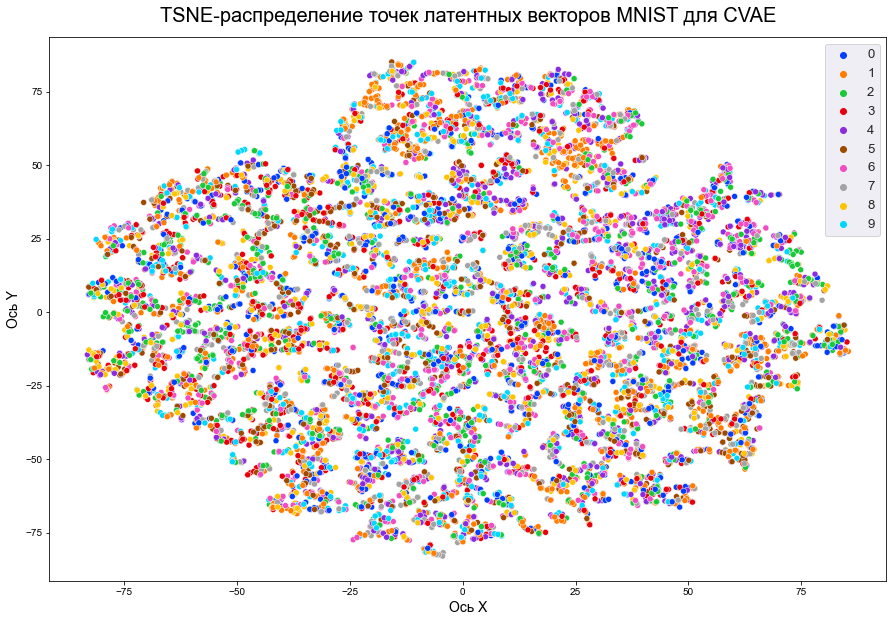

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set(font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright')
ax.set_title('TSNE-распределение точек латентных векторов MNIST для CVAE', fontsize=20, pad=15)
ax.set_xlabel('Ось X', fontsize=14)
ax.set_ylabel('Ось Y', fontsize=14)
plt.show()

Признаки латентного пространства равномерно распределены в виде облака на двумерной плоскости. Классы не кластеризованы как в случае с VAE. При этом, объекты кодируются соответствующими метками, которые позволяют декодеру интерпретировать любую точку скрытого пространства в соответствие с заданной меткой класса. Полученный графический вывод можно определить как единое пространство стилей для группы различных классов изображений.

# Denoising

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

In [8]:
# Создадим данные для последующего накладывания шума
data_n, attrs_n, _ = fetch_dataset()

In [22]:
# # Функция для добавления шума на изображения
# def add_noise(x):
#     noise_factor = 0.5
#     x = x + noise_factor * torch.normal(0, 1, size=x.shape) 
#     return x

In [37]:
def add_noise(tensor, noise_factor=0.2):
    '''Функция добавлет Гауссовый шум и возвращает
    нормализованный тензор'''
    noise = torch.randn(tensor.shape)
    unnorm = (tensor * (1 - noise_factor) + noise * noise_factor).numpy()
    batch_min = unnorm.min((2,3), keepdims=True)
    batch_max = unnorm.max((2,3), keepdims=True)
    normalized = torch.FloatTensor((unnorm - batch_min) / (batch_max - batch_min))
    return normalized

In [10]:
# Разобъём датасет на тренировочную и валидационную части
train_photos_n, val_photos_n, train_attrs_n, val_attrs_n = train_test_split(data_n, attrs_n, train_size=0.8, shuffle=False)

In [11]:
# Создадим даталоадеры для обучения модели
BATCH_SIZE = 32

# numpy.ndarray to tensor_float32 [32, 128, 128, 3] --> [32, 3, 128, 128]
train_photos_t_n = torch.FloatTensor(train_photos_n).permute(0, 3, 1, 2) 
val_photos_t_n = torch.FloatTensor(val_photos_n).permute(0, 3, 1, 2) 

train_loader_n = torch.utils.data.DataLoader(train_photos_t_n, batch_size=BATCH_SIZE, num_workers=2)
val_loader_n = torch.utils.data.DataLoader(val_photos_t_n, batch_size=BATCH_SIZE, num_workers=2)

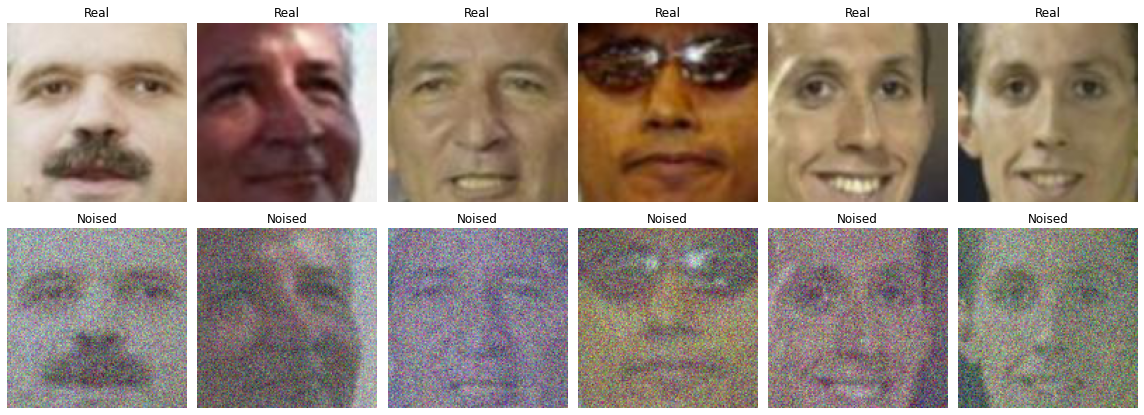

In [38]:
# Проверим работу функции add_noise на случайных изображениях
images = next(iter(val_loader_n))
noise_images = add_noise(copy.deepcopy(images))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(noise_images[j].permute(1,2,0))
            axes.set_title('Noised')
        axes.axis('off')
plt.tight_layout()
plt.show()

Подготовим обучение модели

In [39]:
criterion = F.mse_loss
autoencoder_n = Autoencoder().to(device)
optimizer = torch.optim.AdamW(autoencoder_n.parameters(), lr=3e-4)

In [40]:
def train_vanilla_noise(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []
    
    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf
    
    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
        
    for epoch in range(epochs):
        # Train mode
        model.train()
        train_losses_per_epoch = []
        for i, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch_noised = add_noise(copy.deepcopy(X_batch))
            X_batch = X_batch.to(device)
            X_batch_noised = X_batch_noised.to(device)
            reconstructed, latent = model(X_batch_noised)
            loss = criterion(reconstructed, X_batch)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        
        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)
        
        if is_scheduler:
            scheduler.step()
        
        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                X_batch_val_noised = add_noise(copy.deepcopy(X_batch_val))
                X_batch_val = X_batch_val.to(device)
                X_batch_val_noised = X_batch_val_noised.to(device)
                reconstructed_val, latent_val = model(X_batch_val_noised)
                loss_val = criterion(reconstructed_val, X_batch_val)
                val_losses_per_epoch.append(loss_val.item())
        
        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))
        
        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())
            
        # Visualisations
        clear_output(wait=True)
    
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle(f"epoch:{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 5)}, val_loss:{round(val_loss_mean, 5)}, best_val_loss:{round(best_loss_val, 5)}")

        gs1 = GridSpec(2, 5, left=0.0001, right=0.95, wspace=0.05)
        
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax1.imshow(X_batch_val_noised[0].detach().cpu().permute(1,2,0))
        ax1.set_title('Real')
        ax1.axis('off') 
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax2.imshow(X_batch_val_noised[1].detach().cpu().permute(1,2,0))
        ax2.set_title('Real')
        ax2.axis('off') 
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax3.imshow(X_batch_val_noised[2].detach().cpu().permute(1,2,0))
        ax3.set_title('Real')
        ax3.axis('off') 
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax4.imshow(X_batch_val_noised[3].detach().cpu().permute(1,2,0))
        ax4.set_title('Real')
        ax4.axis('off') 
        ax5 = fig.add_subplot(gs1[:-1, -1])
        ax5.imshow(X_batch_val_noised[4].detach().cpu().permute(1,2,0))
        ax5.set_title('Real')
        ax5.axis('off') 

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax6.imshow(reconstructed_val[0].detach().cpu().permute(1,2,0))
        ax6.set_title('Reconstructed')
        ax6.axis('off') 
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax7.imshow(reconstructed_val[1].detach().cpu().permute(1,2,0))
        ax7.set_title('Reconstructed')
        ax7.axis('off')
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax8.imshow(reconstructed_val[2].detach().cpu().permute(1,2,0))
        ax8.set_title('Reconstructed')
        ax8.axis('off')
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax9.imshow(reconstructed_val[3].detach().cpu().permute(1,2,0))
        ax9.set_title('Reconstructed')
        ax9.axis('off')
        ax10 = fig.add_subplot(gs1[-1, 4])
        ax10.imshow(reconstructed_val[4].detach().cpu().permute(1,2,0))
        ax10.set_title('Reconstructed')
        ax10.axis('off')

        gs2 = GridSpec(2, 2, left=1.01, right=2.0, hspace=0.05)
        
        ax11 = fig.add_subplot(gs2[:, :-1])
        ax11.plot(np.arange(len(train_losses)), train_losses, label='Train')
        ax11.plot(np.arange(len(val_losses)), val_losses, label='Validation')
        ax11.set_ylim(0, max(train_losses+val_losses))
        ax11.set_xlabel('Epoch')
        ax11.set_title('MSE loss')
        ax11.legend()

        plt.show()
        
        # Delete cache
        X_batch.to('cpu')
        del X_batch
        X_batch_val.to('cpu')
        del X_batch_val
        torch.cuda.empty_cache()
        
        # load best model weights
        model.load_state_dict(best_model_weights)

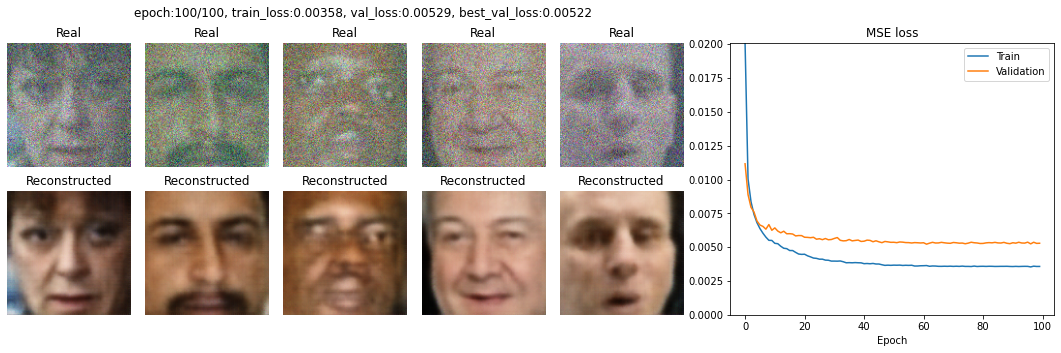

In [41]:
train_vanilla_noise(model=autoencoder_n, 
                    optimizer=optimizer, 
                    criterion=criterion, 
                    epochs=100, 
                    train_loader=train_loader_n, 
                    val_loader=val_loader_n)

In [42]:
# Save model
torch.save(autoencoder_n.state_dict(), 'autoencoder_denoise_norm.pt')

In [ ]:
# Load model
autoencoder_n = Autoencoder().to(device)
autoencoder_n.load_state_dict(torch.load('autoencoder_denoise_norm.pt', map_location=device))
autoencoder_n.eval()

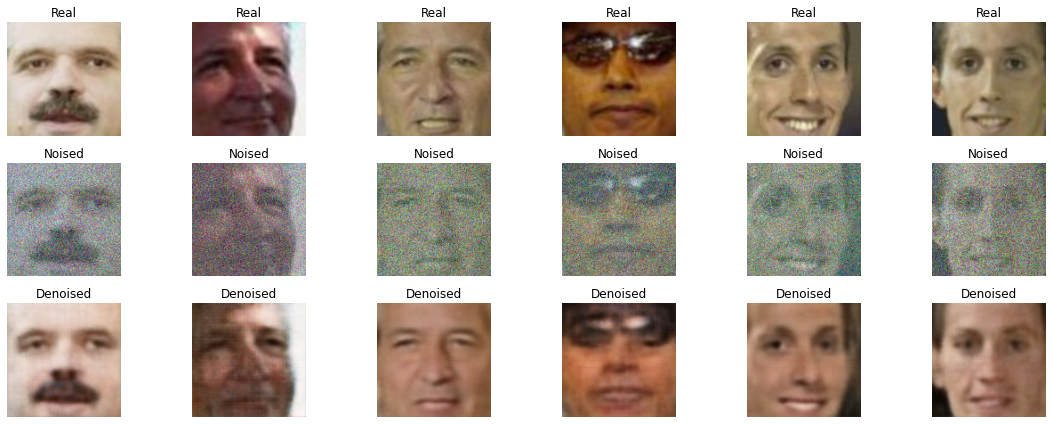

In [43]:
# Выведем первые Х картинок и их denoise из val выборки на экран
images = next(iter(val_loader_n))
noise_images = add_noise(copy.deepcopy(images))
autoencoder_n.eval()
with torch.no_grad():
    reconstructed, latent = autoencoder_n(noise_images.to(device))

fig, ax = plt.subplots(3, 6, figsize=(16, 6))
for i in range(3):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        if i == 1:
            axes.imshow(noise_images[j].permute(1,2,0))
            axes.set_title('Noised')     
        if i == 2:
            axes.imshow(reconstructed[j].cpu().permute(1,2,0))
            axes.set_title('Denoised')
        axes.axis('off')
plt.tight_layout()
plt.show()

# Image Retrieval

1. Получим латентные представления всех лиц тренировочного датасета.
2. Обучим на них LSHForest `(sklearn.neighbors.LSHForest)`.
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочнойго датасета.
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем.

In [12]:
# Получим латентные представления всех лиц тренировочного датасета
latents = torch.FloatTensor()
itr = iter(train_loader)
for i in range(len(train_loader)):
    images = next(itr)
    autoencoder.eval()
    with torch.no_grad():
        _, latent = autoencoder(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [13]:
def get_test_latent(image):
    '''Получает на вход изображение,
    возвращает латентное представление изображения'''
    image = image.unsqueeze(0)
    autoencoder.eval()
    with torch.no_grad():
        _, latent = autoencoder(image.to(device))
    return latent

In [14]:
def get_similar_latents(n_neighbors, latents, test_latent):
    '''Получает на вход количество соседей, latents и latent тестового изображения, 
    возвращает batch латентных векторов ближайщих к тестовому и массив с дистанциями'''
    
    nnbrs = NearestNeighbors(n_neighbors=5).fit(latents)
    distances, num_latents = nnbrs.kneighbors(test_latent.to('cpu'), n_neighbors=n_neighbors)
    n_latents = torch.FloatTensor() 
    
    for i in num_latents:
        n_latents = torch.cat((n_latents, latents[i].cpu()))
            
    return distances, n_latents, num_latents

In [15]:
def show_similar(test_image, n_latents, distances, num_latents):
    '''Принимает на вход тестовое изображение, latents ближайщих к тестовому
    изображений массив с дистанциями и массив индексов латнтных представлений,
    отрисовывает результат'''
    
    plt.figure(figsize=[16, 12])
    plt.subplot(3,4,1)
    plt.imshow(test_image.cpu().numpy().transpose([1,2,0]))
    plt.xticks([])
    plt.yticks([])
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(train_photos_t[num_latents[0][i]].cpu().numpy().transpose([1,2,0]))
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{file_attrs['person'].iloc[num_latents[0][i]]}, \n Distance={round(distances[0][i], 2)}")
    plt.show()

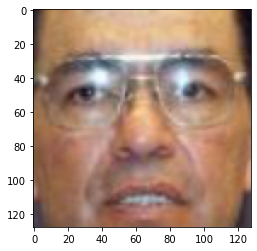

In [63]:
# Возмём любое тестовое изображение
test_image = next(iter(val_loader))[9]
plt.imshow(test_image.cpu().permute(1,2,0))
plt.show()

In [64]:
test_latent = get_test_latent(test_image)

In [65]:
distances, n_latents, num_latents = get_similar_latents(11, latents, test_latent)

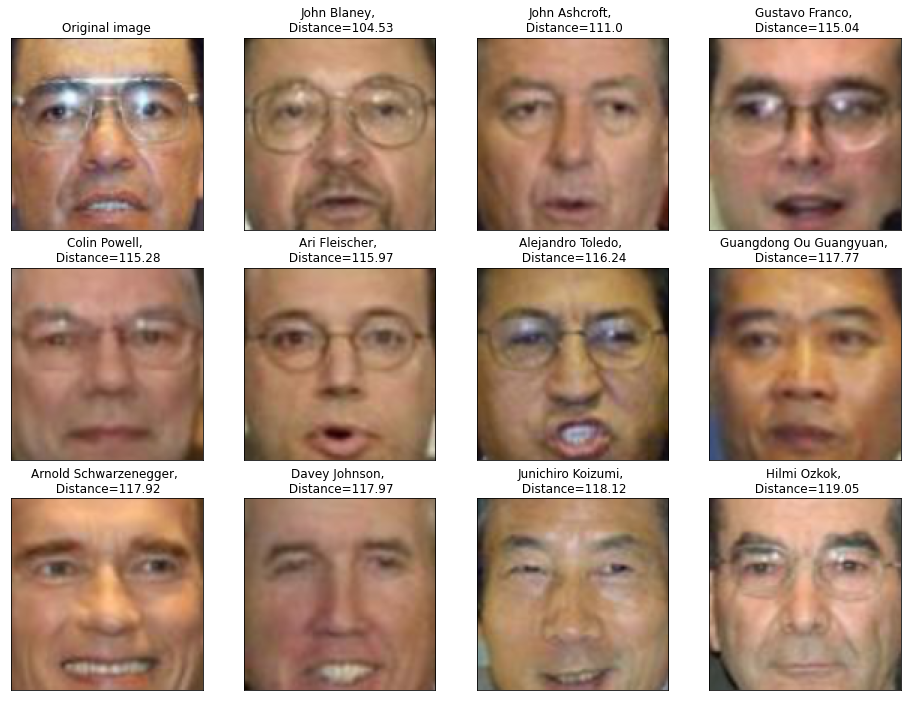

In [66]:
show_similar(test_image, n_latents, distances, num_latents)